**Azure agent for create freshdesk tickets**

This script demonstrates how to create and run a custom AI agent using Azure AI Projects
that can interact with external service Freshdesk support tickets to create tickets for the user.

Key Features:
- Utilizes Azure AI Projects to create an intelligent agent
- Implements a custom function to create Freshdesk tickets via API
- Provides an interactive command-line interface for agent interaction
- Showcases integration of custom tools with an AI agent

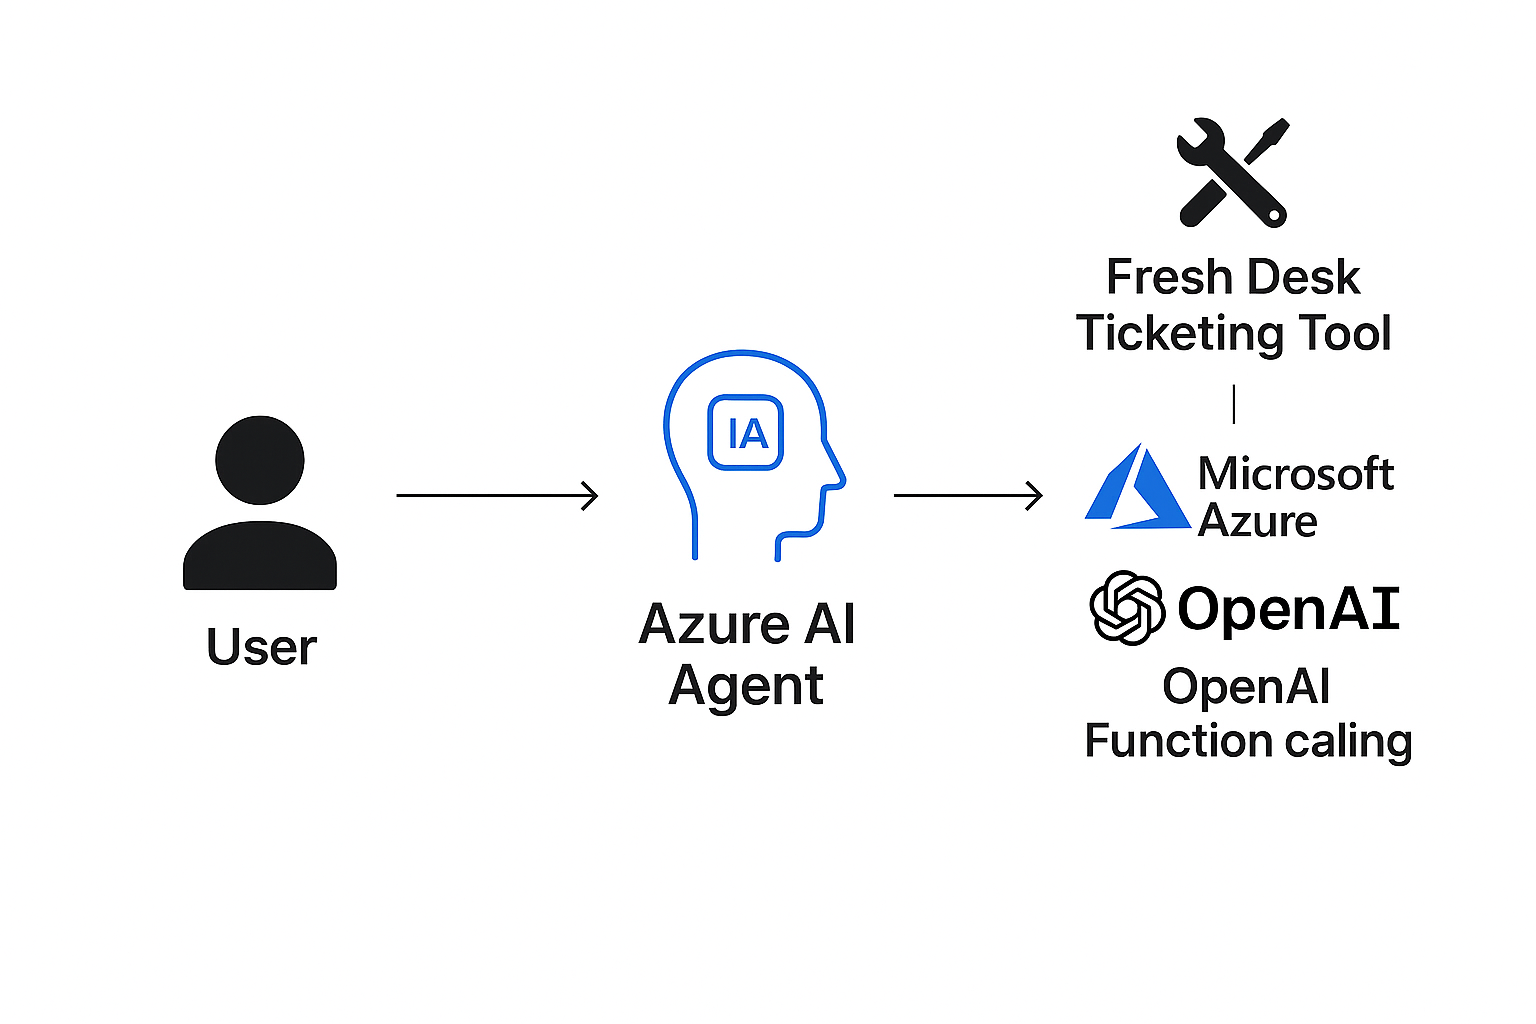

In [ ]:
# Installs the Azure AI Projects SDK and Azure Identity library for authentication
#!pip install azure-ai-projects==1.0.0b10 azure-identity==1.21.0 load_dotenv

In [1]:

import os
from dotenv import load_dotenv
load_dotenv('agents.env')
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
TENANT_ID = os.getenv("TENANT_ID")
PROJECT_ENDPOINT = os.getenv("PROJECT_ENDPOINT")
print(PROJECT_ENDPOINT)


https://waqkh-mgawgzn2-eastus2.services.ai.azure.com/api/projects/waqkh-mgawgzn2-eastus2_project


In [2]:
from typing import Any, Callable, Set
import requests
import json


# Custom function to create Freshdesk tickets
def create_freshdesk_ticket(Email: str, Subject: str) -> str:
    """
    Creates a ticket in Freshdesk via its API.
    :param Email (str): The email of the user reporting the issue.
    :param Subject (str): Subject line of the support ticket.
    :return: Ticket information as a JSON string.
    :rtype: str
    """
    # Freshdesk domain and API key configuration
    FRESHDESK_DOMAIN = os.getenv("FRESHDESK_DOMAIN")
    FRESHDESK_API_KEY = os.getenv("FRESHDESK_API_KEY")


    # Construct the API endpoint URL
    url = f"https://{FRESHDESK_DOMAIN}/api/v2/tickets"


    # Prepare ticket data for API request
    ticket_data = {
        "email": Email,
        "subject": Subject,
        "description": "This is a ticket created via Azure AI Agent Service.",
        "priority": 2,  # Medium priority
        "status": 2,    # Open status
        "tags": ["API", "Python"]  # Additional ticket metadata
    }

    # Set up request headers
    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json",
    }

    # Send POST request to Freshdesk API
    response = requests.post(
        url,
        auth=(FRESHDESK_API_KEY, "X"),  # Authentication using API key
        headers=headers,
        data=json.dumps(ticket_data),
    )

    # Process and return API response
    if response.status_code == 201:
        return json.dumps(response.json(), indent=4)
    else:
        return json.dumps({"error": response.text, "status_code": response.status_code}, indent=4)

# Collect user functions to be used as tools
user_functions: Set[Callable[..., Any]] = {create_freshdesk_ticket}

In [ ]:
import os  # Provides a way to interact with the operating system, such as accessing environment variables.
import json  # Used for working with JSON data (e.g., parsing and serializing JSON).
import requests  # A library for making HTTP requests to interact with web APIs.
from azure.ai.projects import AIProjectClient  # Provides the main client to interact with Azure AI Project services.
from azure.identity import DefaultAzureCredential, ClientSecretCredential  # Used for authenticating with Azure using credentials.
from azure.ai.agents.models import FunctionTool, ToolSet  # Imports models to define custom functions and toolsets for the AI agent.

# Main execution block
if __name__ == "__main__":
    # Configure Azure credentials using environment variables
    credential = ClientSecretCredential(
        tenant_id=os.getenv("TENANT_ID"),
        client_id=os.getenv("CLIENT_ID"),
        client_secret=os.getenv("CLIENT_SECRET")
    )

    # Initialize Azure AI Project Client
    project_client = AIProjectClient(
        credential=credential,
        endpoint=os.environ["PROJECT_ENDPOINT"]  # Connection string from environment
    )

    # Create toolset with custom functions
    functions = FunctionTool(user_functions)
    toolset = ToolSet()
    toolset.add(functions)

    project_client.agents.enable_auto_function_calls(tools=toolset)

    # Create the Azure AI Agent with specified configuration
    agent = project_client.agents.create_agent(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],
        name="freshdesk-agent",
        instructions="You are a helpful agent who can create support tickets",
        toolset=toolset
    )
    print(f"Created agent, ID: {agent.id}")

    # Create a conversation thread
    thread = project_client.agents.threads.create()
    print(f"Created thread, ID: {thread.id}")

    # Interactive conversation loop
    while True:
        # Prompt for user input
        user_input = input("User: ")

        # Exit condition
        if user_input.lower() == "end":
            print("Ending the conversation.")
            break

        # Send user message to the agent
        message = project_client.agents.messages.create(
            thread_id=thread.id,
            role="user",
            content=user_input,
        )

        # Process the agent's run
        run = project_client.agents.runs.create_and_process(thread_id=thread.id, agent_id=agent.id)

        # Check for run failures
        if run.status == "failed":
            print(f"Run failed: {run.last_error}")
            break

        # Retrieve and display agent's response
        latest_message = next(msg for msg in project_client.agents.messages.list(thread_id=thread.id) if msg.role == "assistant")
        if agent_response := next((content.text.value for content in latest_message.content if content.type == "text"), None):
            print(f"Agent: {agent_response}")

    # Optional: Delete the agent
    project_client.agents.delete_agent(agent.id)
    print("Conversation ended")